# Tutorial: Creating a Multi-Agent System with Haystack

- **Level**: Advanced
- **Time to complete**: 20 minutes
- **Components Used**: [`Agent`](https://docs.haystack.deepset.ai/docs/agent), [`DuckduckgoApiWebSearch`](https://haystack.deepset.ai/integrations/duckduckgo-api-websearch), [`OpenAIChatGenerator`](https://docs.haystack.deepset.ai/docs/openaichatgenerator), [`DocumentWriter`](https://docs.haystack.deepset.ai/docs/documentwriter)
- **Prerequisites**: You need an [OpenAI API Key](https://platform.openai.com/api-keys), and a [Notion Integration](https://developers.notion.com/docs/create-a-notion-integration#getting-started) set up beforehand
- **Goal**: After completing this tutorial, you'll have learned how to build a multi-agent system in Haystack where each agent is specialized for a specific task.

## Overview
**Multi-agent** systems are made up of several intelligent agents that work together to solve complex tasks more effectively than a single agent alone. Each agent takes on a specific role or skill, allowing for distributed reasoning, task specialization, and smooth coordination within one unified system.

What makes this possible in Haystack is the ability to use **agents as tools** for other agents. This powerful pattern allows you to compose modular, specialized agents and orchestrate them through a main agent that delegates tasks based on context.

In this tutorial, you'll build a simple yet powerful multi-agent setup with one main agent and two sub-agents: one focused on researching information, and the other on saving it.

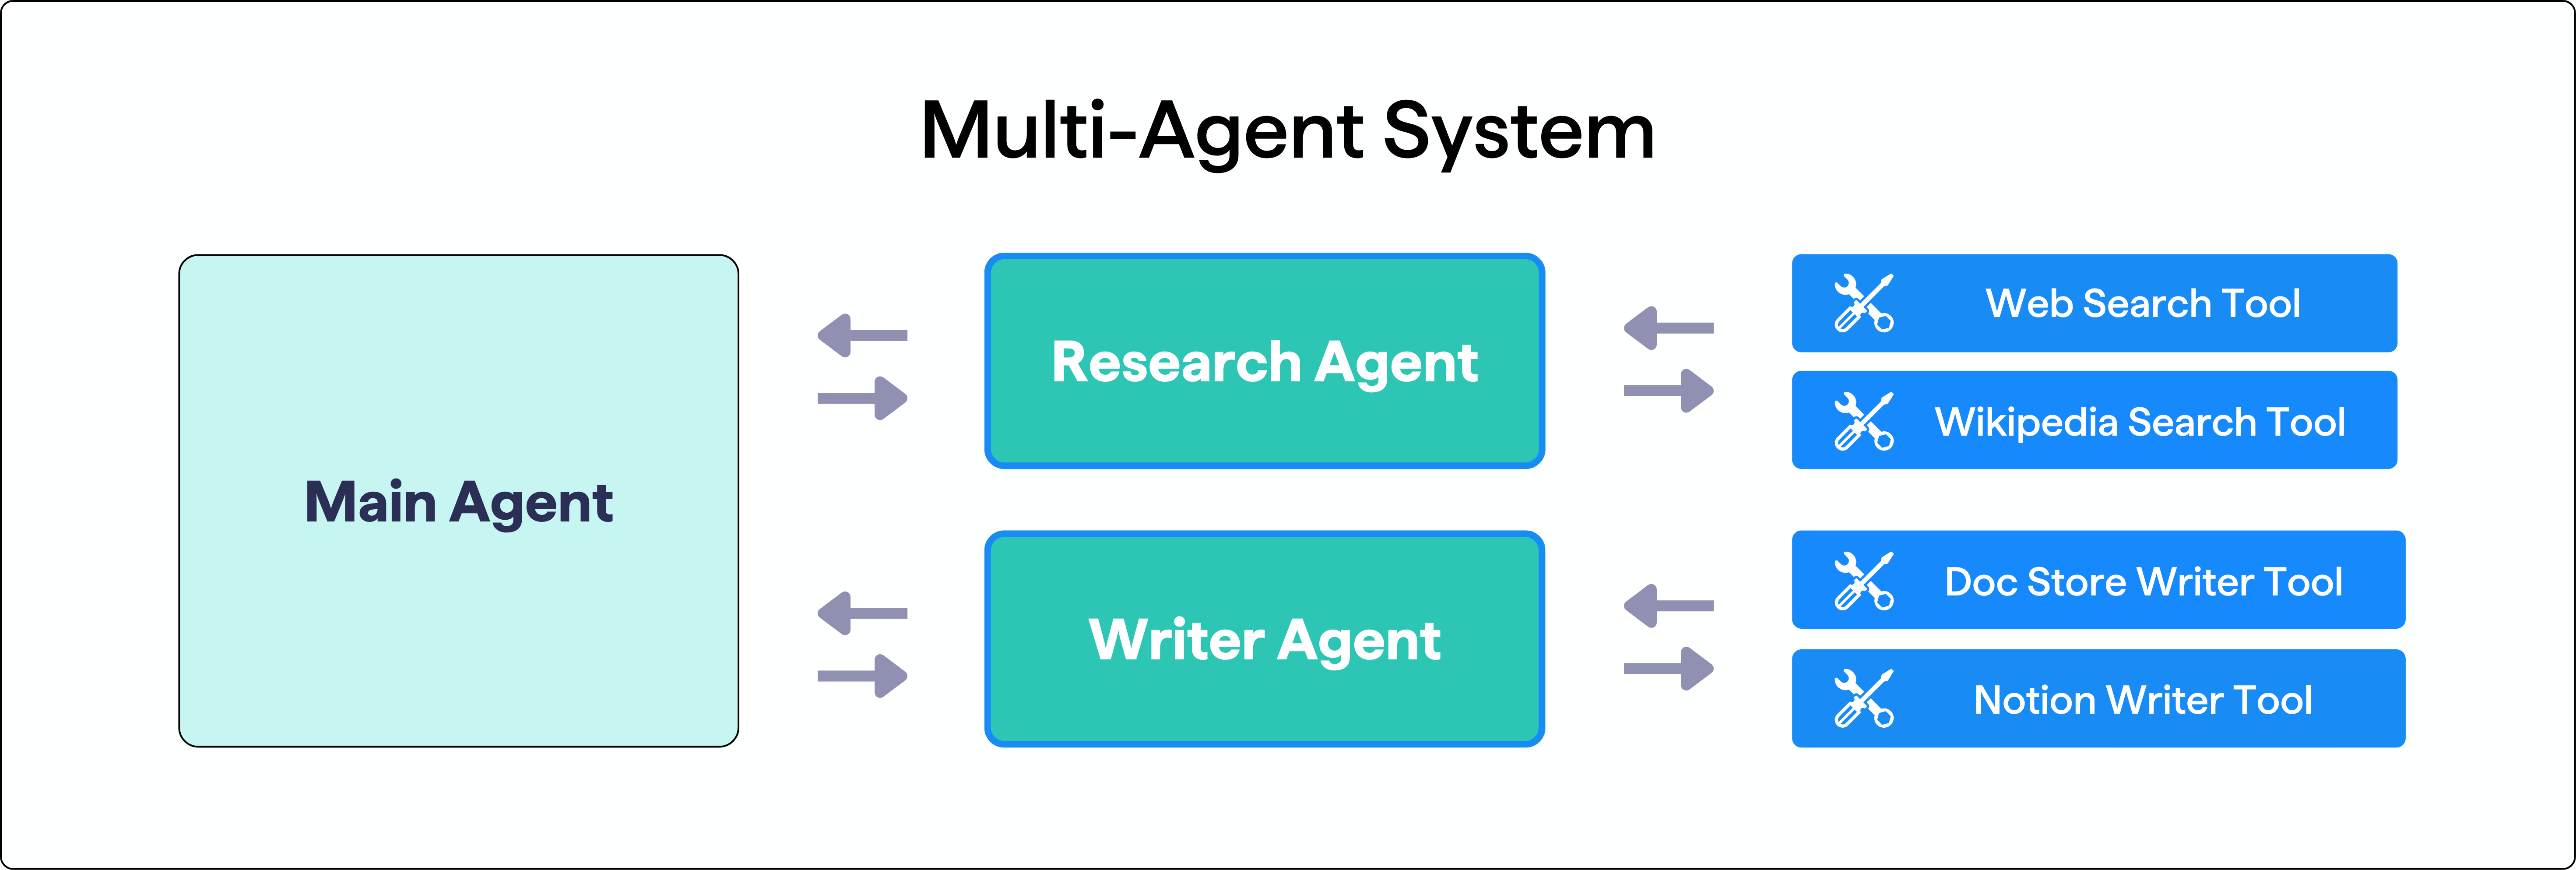

## Preparing the Environment

First, let's install required packages:

In [ ]:
%%bash

pip install -q haystack-ai duckduckgo-api-haystack

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 514.7/514.7 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.7/96.7 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 55.0 MB/s eta 0:00:00


### Enter API Keys

Enter API keys required for this tutorial. Learn how to get your `NOTION_API_KEY` after creating a Notion integration [here](https://developers.notion.com/docs/create-a-notion-integration#get-your-api-secret)

In [ ]:
from getpass import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass("Enter your OpenAI API key:")
if not os.environ.get("NOTION_API_KEY"):
    os.environ["NOTION_API_KEY"] = getpass("Enter your NOTION API key:")

## Creating Tools for the Research Agent

Let's set up the tools for your research agent. Its job is to gather information on a topic, and in this tutorial, it will use just two sources: the whole web and Wikipedia. In other scenarios, it could also connect to a retrieval or RAG pipeline linked to a document store.

You'll create two [`ComponentTool`s](https://docs.haystack.deepset.ai/docs/componenttool) using the [DuckduckgoApiWebSearch](https://haystack.deepset.ai/integrations/duckduckgo-api-websearch) component: one for general web search, and one limited to Wikipedia by setting `allowed_domain`.

One more step before wrapping up: `DuckduckgoApiWebSearch` returns a list of documents, but the `Agent` works best when tools return a single string in this setting. To handle that, define a `doc_to_string` function that converts the Document list into a string. This function, used as the `outputs_to_string` handler, can also add custom elements like filenames or links before returning the output.

In [ ]:
from haystack.tools import ComponentTool
from duckduckgo_api_haystack import DuckduckgoApiWebSearch


def doc_to_string(documents) -> str:
    """
    Handles the tool output before conversion to ChatMessage.
    """
    result_str = ""
    for document in documents:
        result_str += f"File Content for {document.meta['link']}\n\n {document.content}"

    if len(result_str) > 150_000:  # trim if the content is too large
        result_str = result_str[:150_000] + "...(large file can't be fully displayed)"

    return result_str


web_search = ComponentTool(
    component=DuckduckgoApiWebSearch(top_k=5, backend="lite"),
    name="web_search",
    description="Search the web",
    outputs_to_string={"source": "documents", "handler": doc_to_string},
)

wiki_search = ComponentTool(
    component=DuckduckgoApiWebSearch(top_k=5, backend="lite", allowed_domain="https://en.wikipedia.org"),
    name="wiki_search",
    description="Search Wikipedia",
    outputs_to_string={"source": "documents", "handler": doc_to_string},
)

If you're hitting rate limits with DuckDuckGo, you can use [`SerperDevWebSearch`](https://docs.haystack.deepset.ai/docs/serperdevwebsearch) as your websearch component for these tools. You need to enter the free [Serper API Key](https://serper.dev/api-key) to use `SerperDevWebSearch`. 

In [ ]:
# from getpass import getpass
# import os

# from haystack.components.websearch import SerperDevWebSearch
# from haystack.tools import ComponentTool

# if not os.environ.get("SERPERDEV_API_KEY"):
#     os.environ["SERPERDEV_API_KEY"] = getpass("Enter your SERPER API key:")

# web_search = ComponentTool(
#     component=SerperDevWebSearch(top_k=5),
#     name="web_search",
#     description="Search the web",
#     outputs_to_string={"source": "documents", "handler": doc_to_string},
# )

# wiki_search = ComponentTool(
#     component=SerperDevWebSearch(top_k=5, allowed_domains=["https://www.wikipedia.org/", "https://en.wikipedia.org"]),
#     name="wiki_search",
#     description="Search Wikipedia",
#     outputs_to_string={"source": "documents", "handler": doc_to_string},
# )

## Initializing the Research Agent

Now it's time to bring your research agent to life. This agent will solely responsible for finding information. Use `OpenAIChatGenerator` or any other [chat generator](https://docs.haystack.deepset.ai/docs/generators) that supports function calling.

Pass in the `web_search` and `wiki_search` tools you created earlier. To keep things transparent, enable streaming using the built-in `print_streaming_chunk` function. This will display the agent's tool calls and results in real time, so you can follow its actions step by step.



In [61]:
from haystack.components.agents import Agent
from haystack.dataclasses import ChatMessage
from haystack.components.generators.utils import print_streaming_chunk
from haystack.components.generators.chat import OpenAIChatGenerator

research_agent = Agent(
    chat_generator=OpenAIChatGenerator(model="gpt-4o-mini"),
    system_prompt="""
    You are a research agent that can find information on web or specifically on wikipedia.
    Use wiki_search tool if you need facts and use web_search tool for latest news on topics.
    Use one tool at a time. Try different queries if you need more information.
    Only use the retrieved context, do not use your own knowledge.
    Summarize the all retrieved information before returning response to the user.
    """,
    tools=[web_search, wiki_search],
    streaming_callback=print_streaming_chunk,
)

In [62]:
result = research_agent.run(
    messages=[ChatMessage.from_user("Can you tell me about Florence Nightingale's contributions to nursery?")]
)



[TOOL CALL]
Tool: wiki_search 
Arguments: {"query":"Florence Nightingale contributions to nursing"}



[TOOL RESULT]
File Content for https://en.wikipedia.org/wiki/Florence_Nightingale

 She significantly reduced death rates by improving hygiene and living standards. Nightingale gave nursing a favourable reputation and became an icon of ...File Content for https://en.wikipedia.org/wiki/Nightingale_Pledge

 The Nightingale Pledge is a statement of the ethics and principles of the nursing profession in the United States, and it is not used outside the US.File Content for https://en.wikipedia.org/wiki/Florence_Nightingale_Faculty_of_Nursing_and_Midwifery

 Established on 9 July 1860 by Florence Nightingale, the founder of modern nursing, it was a model for many similar training schools through the UK, Commonwealth ...File Content for https://en.wikipedia.org/wiki/History_of_nursing

 The Crimean War was a significant development in nursing history when English nurse Florence Nightingale

Print the final answer of the agent through `result["last_message"].text`

In [63]:
print("Final Answer:", result["last_message"].text)

Final Answer: Florence Nightingale is widely recognized as the founder of modern nursing due to her significant contributions to the profession, particularly during and after the Crimean War. Here are the key aspects of her contributions:

1. **Improvement of Hygiene and Standards**: Nightingale played a crucial role in reducing death rates in military hospitals by implementing better hygiene practices and improving living conditions for soldiers. Her emphasis on sanitation and cleanliness laid the groundwork for future nursing practices.

2. **Establishment of Nursing Education**: In 1860, she founded the Nightingale School of Nursing at St. Thomas' Hospital in London, which became a model for nursing training programs worldwide. This institution was pivotal in professionalizing nursing and training skilled nurses.

3. **Statistical Analysis**: Nightingale utilized statistics to demonstrate the impact of sanitation on health outcomes, making a compelling case for reform in healthcare 

## Creating Tools for the Writer Agent

Next, let's set up tools for your second agent, the writer agent. Its job is to save content, either to Notion or to a document store (to `InMemoryDocumentStore` in this tutorial).

### Notion Writer Tool

Start by creating a [custom component](https://docs.haystack.deepset.ai/docs/custom-components) that can add a new page to a Notion workspace given the page title and content. To use it, you'll need an active [Notion integration](https://developers.notion.com/docs/create-a-notion-integration) with [access to a parent page](https://developers.notion.com/docs/create-a-notion-integration#give-your-integration-page-permissions) where new content will be stored. Grab the [`page_id`](https://developers.notion.com/docs/create-a-notion-integration#environment-variables) of that parent page from its URL, and pass it as an init parameter when initializing the component.

Here's a basic implementation to get you started:

In [36]:
from haystack import component
from typing import Optional
from haystack.utils import Secret
import requests


@component
class NotionPageCreator:
    """
    Create a page in Notion using provided title and content.
    """

    def __init__(
        self,
        page_id: str,
        notion_version: str = "2022-06-28",
        api_key: Secret = Secret.from_env_var("NOTION_API_KEY"),  # to use the environment variable NOTION_API_KEY
    ):
        """
        Initialize with the target Notion database ID and API version.
        """
        self.api_key = api_key
        self.notion_version = notion_version
        self.page_id = page_id

    @component.output_types(success=bool, status_code=int, error=Optional[str])
    def run(self, title: str, content: str):
        """
        :param title: The title of the Notion page.
        :param content: The content of the Notion page.
        """
        headers = {
            "Authorization": f"Bearer {self.api_key.resolve_value()}",
            "Content-Type": "application/json",
            "Notion-Version": self.notion_version,
        }

        payload = {
            "parent": {"page_id": self.page_id},
            "properties": {"title": [{"text": {"content": title}}]},
            "children": [
                {
                    "object": "block",
                    "type": "paragraph",
                    "paragraph": {"rich_text": [{"type": "text", "text": {"content": content}}]},
                }
            ],
        }

        response = requests.post("https://api.notion.com/v1/pages", headers=headers, json=payload)

        if response.status_code == 200 or response.status_code == 201:
            return {"success": True, "status_code": response.status_code}
        else:
            return {"success": False, "status_code": response.status_code, "error": response.text}

Give the component a quick test to confirm it's working properly.

In [30]:
notion_writer = NotionPageCreator(page_id="<your_page_id>")
notion_writer.run(title="My first page", content="The content of my first page")

{'success': True, 'status_code': 200}

> 💡 When turning a custom component into a tool using `ComponentTool`, make sure its input parameters are well-defined. You can do this in one of two ways:
1. Pass a `properties` dictionary to `ComponentTool`, or
2. Use parameter annotations in the `run` method's docstring, like so:
```python
    def run(self, title: str, content: str):
        """
        :param title: The title of the Notion page.
        :param content: The content of the Notion page.
        """
```
This approach also applies to setting the tool's `description`.


In [38]:
from haystack.tools import ComponentTool

notion_writer = ComponentTool(
    component=NotionPageCreator(page_id="<your_page_id>"),
    name="notion_writer",
    description="Use this tool to write/save content to Notion.",
)
notion_writer.parameters  # see how parameters are automatically generated by the ComponentTool

{'properties': {'title': {'description': 'The title of the Notion page.',
   'type': 'string'},
  'content': {'description': 'The content of the Notion page.',
   'type': 'string'}},
 'required': ['title', 'content'],
 'type': 'object'}

### Document Store Writer Tool

Let's now build the other tool for the writer agent, this one will save content to an [InMemoryDocumentStore](https://docs.haystack.deepset.ai/docs/inmemorydocumentstore).

To make this work, start by creating a pipeline that includes the custom `DocumentAdapter` compoenent along with the [DocumentWriter](https://docs.haystack.deepset.ai/docs/documentwriter). Once the pipeline is ready, wrap it in a `SuperComponent` and then convert it into a tool using `ComponentTool`.

> 💡 Tip: You could also [create a tool](https://docs.haystack.deepset.ai/docs/tool#tool-initialization) from a simple function that runs the pipeline. However, the recommended approach is to use `SuperComponent` together with `ComponentTool`, especially if you plan to deploy the tool with [Hayhooks](https://docs.haystack.deepset.ai/docs/hayhooks), since this method supports better serialization. Learn more about `SuperComponents` in [Tutorial: Creating Custom SuperComponents](https://haystack.deepset.ai/tutorials/44_creating_custom_supercomponents)

In [47]:
from haystack import Pipeline, component, Document, SuperComponent
from haystack.components.writers import DocumentWriter
from haystack.document_stores.in_memory import InMemoryDocumentStore
from typing import List


@component
class DocumentAdapter:
    @component.output_types(documents=List[Document])
    def run(self, content: str, title: str):
        return {"documents": [Document(content=content, meta={"title": title})]}


document_store = InMemoryDocumentStore()

doc_store_writer_pipeline = Pipeline()
doc_store_writer_pipeline.add_component("adapter", DocumentAdapter())
doc_store_writer_pipeline.add_component("writer", DocumentWriter(document_store=document_store))
doc_store_writer_pipeline.connect("adapter", "writer")

doc_store_writer = ComponentTool(
    component=SuperComponent(doc_store_writer_pipeline),
    name="doc_store_writer",
    description="Use this tool to write/save content to document store",
    parameters={
        "type": "object",
        "properties": {
            "title": {"type": "string", "description": "The title of the Document"},
            "content": {"type": "string", "description": "The content of the Document"},
        },
        "required": ["title", "content"],
    },
)
doc_store_writer.parameters

{'type': 'object',
 'properties': {'title': {'type': 'string',
   'description': 'The title of the Document'},
  'content': {'type': 'string', 'description': 'The content of the Document'}},
 'required': ['title', 'content']}

## Initializing the Writer Agent

Now let's bring the writer agent to life. Its job is to save or write information using the tools you've set up.

Provide the `notion_writer` and `doc_writer` tools as inputs. In other use cases, you could include tools for other platforms like **Google Drive**, or connect to MCP servers using [MCPTool](https://docs.haystack.deepset.ai/docs/mcptool).

Enable streaming with the built-in `print_streaming_chunk` function to see the agent's actions in real time. Be sure to write a clear and descriptive system prompt to guide the agent's behavior.

Lastly, set `exit_conditions=["notion_writer", "doc_writer"]` so the agent knows to stop once it calls one of these tools. Since this agent's job is to act, not reply, we don't want it to return a final response.

In [48]:
from haystack.components.agents import Agent
from haystack.dataclasses import ChatMessage
from haystack.components.generators.utils import print_streaming_chunk
from haystack.components.generators.chat import OpenAIChatGenerator

writer_agent = Agent(
    chat_generator=OpenAIChatGenerator(model="gpt-4o-mini"),
    system_prompt="""
    You are a writer agent that saves given information to different locations.
    Do not change the provided content before saving.
    Infer the title from the text if not provided.
    When you need to save provided information to Notion, use notion_writer tool.
    When you need to save provided information to document store, use doc_store_writer tool
    If no location is mentioned, use notion_writer tool to save the information.
    """,
    tools=[doc_store_writer, notion_writer],
    streaming_callback=print_streaming_chunk,
    exit_conditions=["notion_writer", "doc_store_writer"],
)

Let's test the Writer Agent

In [ ]:
result = writer_agent.run(
    messages=[
        ChatMessage.from_user(
            """
Save this text on Notion:

Florence Nightingale is widely recognized as the founder of modern nursing, and her contributions significantly transformed the field.
Florence Nightingale's legacy endures, as she set professional standards that have shaped nursing into a respected and essential component of the healthcare system. Her influence is still felt in nursing education and practice today.
"""
        )
    ]
)



[TOOL CALL]
Tool: notion_writer 
Arguments: {"title":"Florence Nightingale: Founder of Modern Nursing","content":"Florence Nightingale is widely recognized as the founder of modern nursing, and her contributions significantly transformed the field. \nFlorence Nightingale's legacy endures, as she set professional standards that have shaped nursing into a respected and essential component of the healthcare system. Her influence is still felt in nursing education and practice today."}



[TOOL RESULT]
{'success': True, 'status_code': 200}



## Creating the Multi-Agent System

So far, you've built two sub-agents, one for research and one for writing, along with their respective tools. Now it's time to bring everything together into a **single multi-agent system**.

To do this, wrap both `research_agent` and `writer_agent` with `ComponentTool`, then pass them as tools to your `main_agent`. This setup allows the main agent to coordinate the overall workflow by delegating tasks to the right sub-agent, each of which already knows how to handle its own tools.

In [64]:
from haystack.components.agents import Agent
from haystack.components.generators.chat import OpenAIChatGenerator
from haystack.components.generators.utils import print_streaming_chunk

research_tool = ComponentTool(
    component=research_agent,
    description="Use this tool to find information on web or specifically on wikipedia",
    name="research_tool",
)
writer_tool = ComponentTool(
    component=writer_agent,
    description="Use this tool to write content into document store or Notion",
    name="writer_tool",
    outputs_to_string={"source": "last_message"},
)

main_agent = Agent(
    chat_generator=OpenAIChatGenerator(model="gpt-4o-mini"),
    system_prompt="""
    You are an assistant that has access to several tools.
    Understand the user query and use relevant tool to answer the query.
    You can use `research_tool` to make research on web and wikipedia and `writer_tool` to save information into the document store or Notion.
    """,
    streaming_callback=print_streaming_chunk,
    tools=[research_tool, writer_tool],
)

Let's test this multi-agent system!

In [ ]:
from haystack.dataclasses import ChatMessage

result = main_agent.run(
    messages=[
        ChatMessage.from_user(
            """
            Can you research the history of the Silk Road?
            """
        )
    ]
)



[TOOL CALL]
Tool: research_tool 
Arguments: {"messages":[{"role":"user","content":[{"text":"Can you provide an overview of the history of the Silk Road?"}]}]}



[TOOL CALL]
Tool: wiki_search 
Arguments: {"query":"History of the Silk Road"}



[TOOL RESULT]
File Content for https://en.wikipedia.org/wiki/Silk_Road

 The Silk Road was a network of Asian trade routes active from the second century BCE until the mid-15th century. Spanning over 6,400 km (4,000 mi), ...File Content for https://en.wikipedia.org/wiki/Silk_Road_(marketplace)

 The name "Silk Road" comes from a historical network of trade routes started during the Han Dynasty (206 BCE – 220 CE) between Europe, India, China, and many ...File Content for https://en.wikipedia.org/wiki/The_Silk_Roads

 The Silk Roads: A New History of the World is a 2015 non-fiction book written by English historian Peter Frankopan, a historian at the University of Oxford.File Content for https://en.wikipedia.org/wiki/Cities_along_the_Silk_Road

 

In [66]:
result["last_message"].text

'The Silk Road was a vast network of trade routes that facilitated commerce and cultural exchange among various civilizations, primarily between Europe and Asia. Here’s an overview of its history:\n\n- **Time Period**: The Silk Road was active from the 2nd century BCE until the mid-15th century, spanning over 6,400 kilometers (approximately 4,000 miles).\n\n- **Origin of the Name**: The term "Silk Road" comes from the lucrative silk trade that flourished along these routes, a practice that began during the Han Dynasty (206 BCE – 220 CE) under Emperor Wu.\n\n- **Geographical Connections**: The routes connected China with India, Persia, and extended to Europe, allowing not only for the trade of silk but also various commodities such as spices, textiles, and precious stones.\n\n- **Cultural Exchange**: The Silk Road served as a conduit for the exchange of goods, ideas, technologies, and cultures, significantly impacting the development of the civilizations involved.\n\n- **Dynamics Change

In [ ]:
result = main_agent.run(
    messages=[
        ChatMessage.from_user(
            """
            Summarize how RAG pipelines work and save it in Notion
            """
        )
    ]
)



[TOOL CALL]
Tool: research_tool 
Arguments: {"messages":[{"role":"user","content":[{"text":"Summarize how RAG pipelines work."}]}]}



[TOOL CALL]
Tool: wiki_search 
Arguments: {"query":"RAG pipelines"}



[TOOL RESULT]
File Content for https://en.wikipedia.org/wiki/Retrieval-augmented_generation

 Retrieval-augmented generation (RAG) is a technique that enables large language models (LLMs) to retrieve and incorporate new information. With RAG, LLMs do ...File Content for https://en.wikipedia.org/wiki/Prompt_engineering

 GraphRAG (coined by Microsoft Research) is a technique that extends RAG with the use of a knowledge graph (usually, LLM-generated) to allow the model to ...File Content for https://en.wikipedia.org/wiki/Large_language_model

 Retrieval-augmented generation (RAG) is another approach that enhances LLMs by integrating them with document retrieval systems. Given a query, a document ...File Content for https://en.wikipedia.org/wiki/RagTime

 RagTime is a frame-oriented b

## What's next

🎉 Congratulations! You've just built a multi-agent system with Haystack, where specialized agents work together to research and write, each with their own tools and responsibilities. You now have a flexible foundation for building more complex, modular agent workflows.

Curious to keep exploring? Here are a few great next steps:

* [DevOps Support Agent with Human in the Loop](https://haystack.deepset.ai/cookbook/agent_with_human_in_the_loop)
* [Building an Agentic RAG with Fallback to Websearch](https://haystack.deepset.ai/tutorials/36_building_fallbacks_with_conditional_routing)
* [Introduction to Multimodal Text Generation](https://haystack.deepset.ai/cookbook/multimodal_intro)

To stay up to date on the latest Haystack developments, you can [sign up for our newsletter](https://landing.deepset.ai/haystack-community-updates) or [join Haystack discord community](https://discord.gg/Dr63fr9NDS).

